<a href="https://colab.research.google.com/github/swilsonmfc/imbalanced/blob/main/PimaDiabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima Diabetes

# Install

In [1]:
!pip install imblearn

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Kaggle

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [6]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

pima-indians-diabetes-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -q pima-indians-diabetes-database.zip

replace diabetes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [8]:
!ls

diabetes.csv  pima-indians-diabetes-database.zip  sample_data


In [9]:
df = pd.read_csv('diabetes.csv')

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# EDA

In [11]:
def plot_feature(df, feature, outcome='Outcome'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
  df.hist(feature, ax=ax1)
  ax1.set_xlabel(feature)
  ax1.set_title(f'Histogram for {feature}')
  df.boxplot(feature, by='Outcome', ax=ax2)
  ax2.set_ylabel(feature)
  ax2.set_title(f'{feature} grouped by Outcome')
  plt.show();

## Missing
* No missing values in the dataset

In [12]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Pregnancies
* A few instances of large numbers of children 15-16
* Larger variability for positive cases

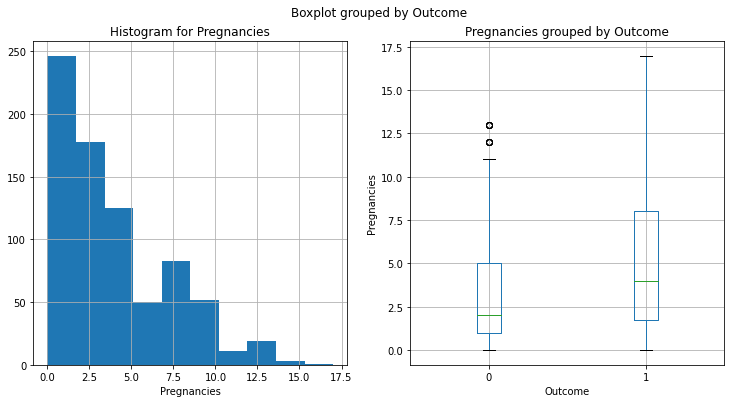

In [13]:
plot_feature(df, 'Pregnancies')

## Glucose
* Some extremely low values - possible outliers
* Higher values for positive outcome

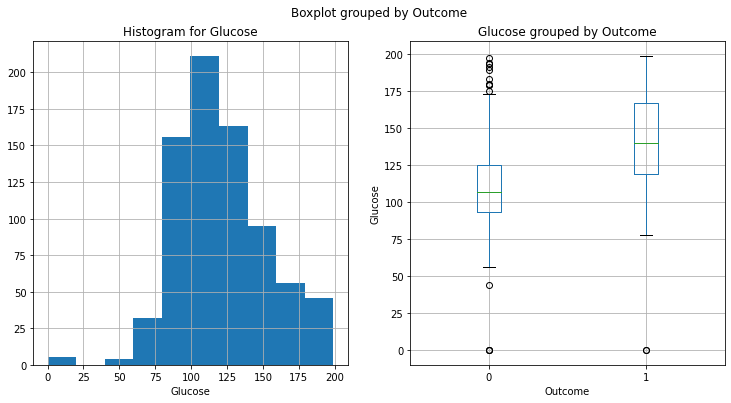

In [14]:
plot_feature(df, 'Glucose')

## Blood Pressure
* Several extremely low values - possible outliers
* Missing values are set to 0

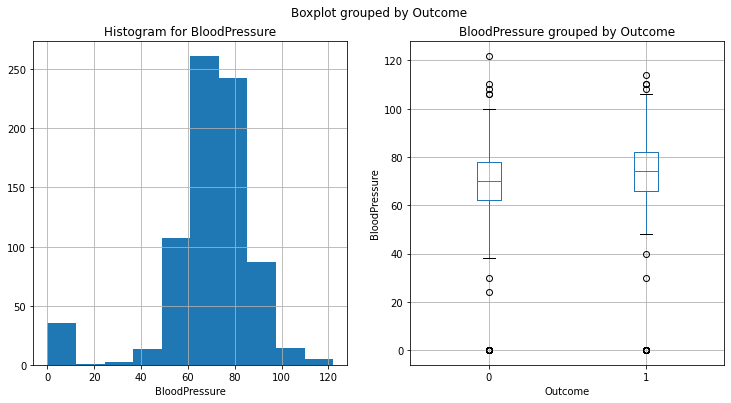

In [15]:
plot_feature(df, 'BloodPressure')

In [16]:
df[df.BloodPressure < 20]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
172,2,87,0,23,0,28.9,0.773,25,0
193,11,135,0,0,0,52.3,0.578,40,1
222,7,119,0,0,0,25.2,0.209,37,0
261,3,141,0,0,0,30.0,0.761,27,1


## Skin Thickness
* Doesn't appear to be very informative

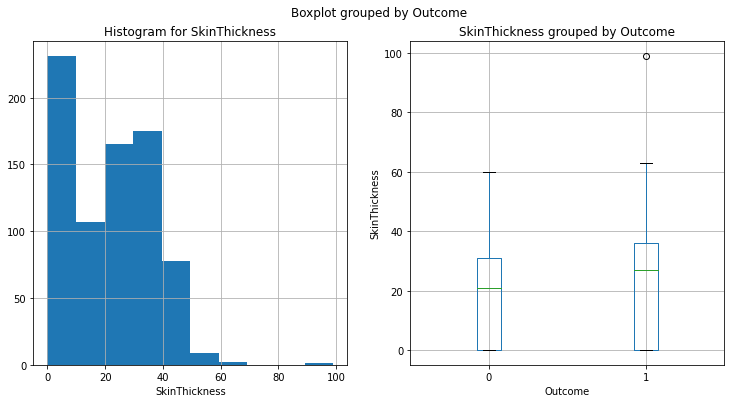

In [17]:
plot_feature(df, 'SkinThickness')

## Insulin

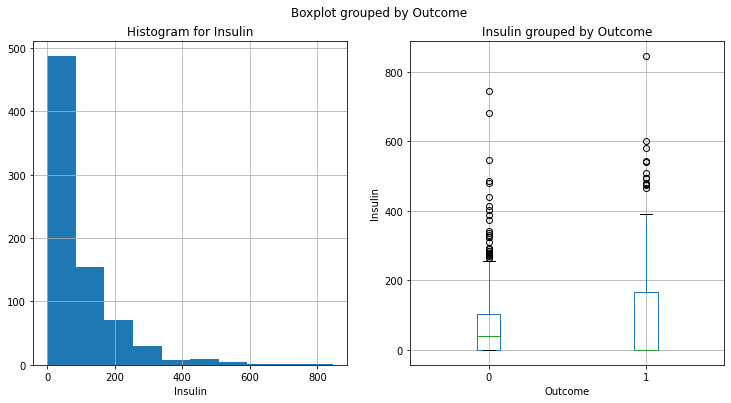

In [18]:
plot_feature(df, 'Insulin')

## BMI
* Gauusian in appearance, may want to winsorize
* We have several values set to 0, possible flag for missing
* With respect to outcome, not a lot of differences

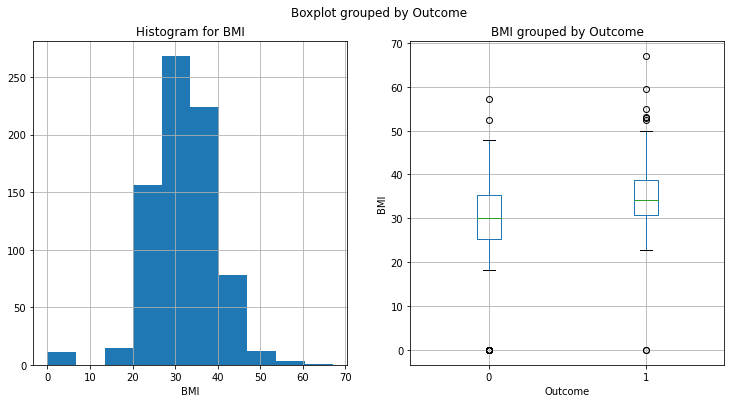

In [19]:
plot_feature(df, 'BMI')

In [20]:
df[df.BMI < 10]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


## Diabetes Pedigree Function

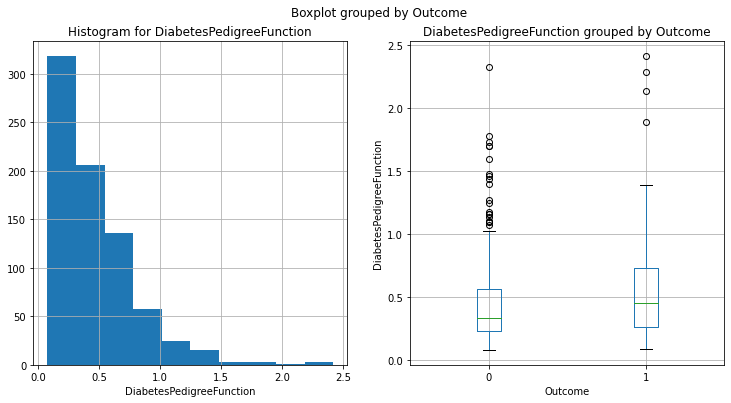

In [21]:
plot_feature(df, 'DiabetesPedigreeFunction')

## Age

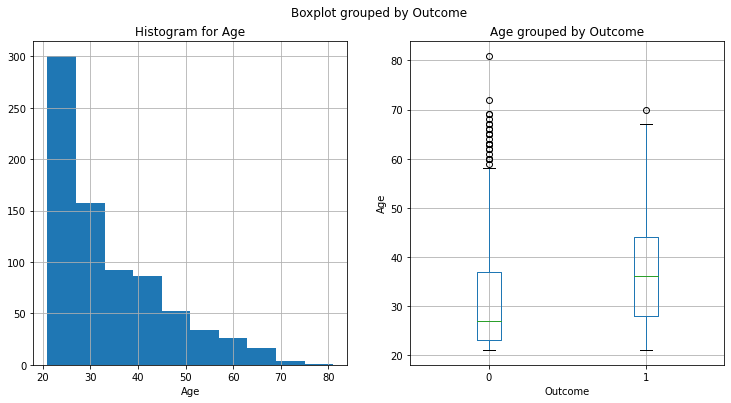

In [22]:
plot_feature(df, 'Age')

## Outcome
* Negative cases outnumber positive cases 2 to 1

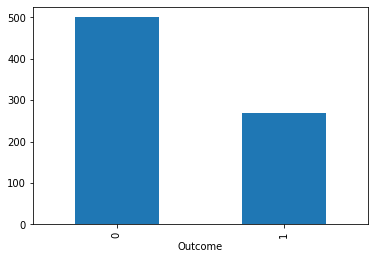

In [23]:
df.groupby('Outcome').size().plot.bar()

# Metrics
* Measure Accuracy and F1 Score
* Where F1 is the harmonic mean of Precision & Recall
* Evaluate performance using F1 Score

# Tracking
A dataframe for tracking results from various techniques

In [39]:
results_df = pd.DataFrame(columns=['Accuracy', 'F1'])

# Data Preparation

## Blood Pressure
* Flag missing blood pressure & impute with median
* Flag missing BMI and impute with median

In [40]:
df['BloodPressureMissing'] = np.where(df.BloodPressure == 0, 1, 0)
median_blood_pressure = np.median(df[df.BloodPressureMissing == 0]['BloodPressure'])
df['BloodPressure'] = np.where(df.BloodPressureMissing == 1, median_blood_pressure, df.BloodPressure)

## BMI

In [41]:
df['BMIMissing'] = np.where(df.BMI == 0, 1, 0)
median_bmi = np.median(df[df.BMIMissing == 0]['BMI'])
df['BMI'] = np.where(df.BMIMissing == 1, median_bmi, df.BMI)

## Training Set

In [42]:
y_train = df['Outcome']
X_train = df.drop(columns=['Outcome'])

In [43]:
y_train

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

# Baseline

## Naive

In [44]:
mode = df.Outcome.mode()
pred = np.repeat([mode], len(df))

accuracy = accuracy_score(df.Outcome, pred)
f1       = f1_score(df.Outcome, pred)

results_df.loc['Baseline'] = [accuracy, f1]
results_df

,Accuracy,F1
Baseline,0.651042,0.0


# XGBoost

## No Balancing

In [45]:
bst = xgb.XGBClassifier()
kfold = KFold(n_splits=10)
accuracy = cross_val_score(bst, X_train, y_train, cv=kfold)
f1       = cross_val_score(bst, X_train, y_train, cv=kfold, scoring='f1')
results_df.loc['XGBoost'] = [np.mean(accuracy), np.mean(f1)]
results_df

,Accuracy,F1
Baseline,0.651042,0.000000
XGBoost,0.756442,0.619904


## Cost Sensitive

In [46]:
pos = len(y_train) // np.sum(y_train)
bst = xgb.XGBClassifier(scale_pos_weight=pos)
kfold = KFold(n_splits=10)
accuracy = cross_val_score(bst, X_train, y_train, cv=kfold)
f1       = cross_val_score(bst, X_train, y_train, cv=kfold, scoring='f1')
results_df.loc['XGBoost + Scale Pos Weight'] = [np.mean(accuracy), np.mean(f1)]
results_df

,Accuracy,F1
Baseline,0.651042,0.000000
XGBoost,0.756442,0.619904
XGBoost + Scale Pos Weight,0.748650,0.667641


## RandomOverSampling

In [47]:
sampler = RandomOverSampler()
X_res, y_res = sampler.fit_resample(X_train, y_train)

bst = xgb.XGBClassifier()
kfold = KFold(n_splits=10)
accuracy = cross_val_score(bst, X_res, y_res, cv=kfold)
f1       = cross_val_score(bst, X_res, y_res, cv=kfold, scoring='f1')
results_df.loc['XGBoost + RandomOverSampling'] = [np.mean(accuracy), np.mean(f1)]
results_df

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,F1
Baseline,0.651042,0.000000
XGBoost,0.756442,0.619904
XGBoost + Scale Pos Weight,0.748650,0.667641
XGBoost + RandomOverSampling,0.809000,0.785892


## UnderSampling

In [48]:
sampler = RandomUnderSampler()
X_res, y_res = sampler.fit_resample(X_train, y_train)

bst = xgb.XGBClassifier()
kfold = KFold(n_splits=10)
accuracy = cross_val_score(bst, X_res, y_res, cv=kfold)
f1       = cross_val_score(bst, X_res, y_res, cv=kfold, scoring='f1')
results_df.loc['XGBoost + RandomUnderSampling'] = [np.mean(accuracy), np.mean(f1)]
results_df

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,Accuracy,F1
Baseline,0.651042,0.000000
XGBoost,0.756442,0.619904
XGBoost + Scale Pos Weight,0.748650,0.667641
XGBoost + RandomOverSampling,0.809000,0.785892
XGBoost + RandomUnderSampling,0.686583,0.429844


# Results
* Using default XGBoost parameters, RandomOverSampling was a superior method measured by 10 fold CV and F1 Score

In [49]:
results_df.sort_values('F1', ascending=False)

,Accuracy,F1
XGBoost + RandomOverSampling,0.809000,0.785892
XGBoost + Scale Pos Weight,0.748650,0.667641
XGBoost,0.756442,0.619904
XGBoost + RandomUnderSampling,0.686583,0.429844
Baseline,0.651042,0.000000


# Complete Example
While this example concludes with a comparison of results, a complete example would typically add:
* Hypertune XGBoost using RandomOverSampling
* Investigate Importance
* Consider / Explain Predictions (Shap / Lime)
* Build / Deploy a final Model